In [16]:
import logging, os
import sys

NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

BASE_PATH = "../../../../local_data/jheaton/"
DATA_PATH = "../../../../local_data/tfds/"
PACKAGES_PATH="../../../../local_data/packages/"
SHAPE_PRED_PATH="../../../../local_data/packages/shape_predictor/"
OUTPUT_PATH = BASE_PATH+"class_09_4_facial_points/"
os.system("mkdir -p " + OUTPUT_PATH)

sys.path.insert(0, PACKAGES_PATH+"stylegan2-ada-pytorch")

SOURCE_NAME= OUTPUT_PATH+"about-jeff-heaton-2020.jpg"
TARGET_NAME= OUTPUT_PATH+"thor.jpg"


In [17]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(SHAPE_PRED_PATH+'shape_predictor_5_face_landmarks.dat')

In [18]:
img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
    raise ValueError("No faces detected")
elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
    pt1 = (shape.part(i).x, shape.part(i).y)
    pt2 = (shape.part(i).x+w, shape.part(i).y+w)
    cv2.rectangle(img,pt1,pt2,(0,255,255),4)
    print(pt1,pt2)

(628, 314) (645, 331)
(569, 318) (586, 335)
(419, 318) (436, 335)
(476, 318) (493, 335)
(527, 419) (544, 436)


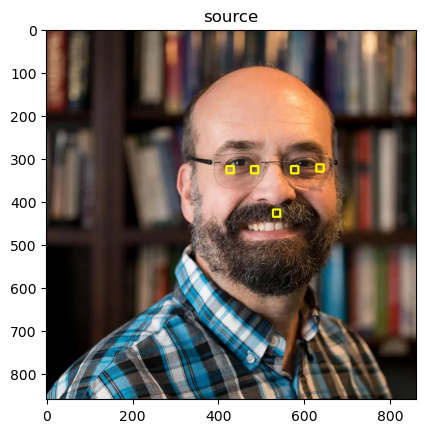

In [19]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

In [20]:
def find_eyes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)

    if len(rects) == 0:
        raise ValueError("No faces detected")
    elif len(rects) > 1:
        raise ValueError("Multiple faces detected")
    
    shape = predictor(gray, rects[0])
    features = []
    
    for i in range(0, 5):
        features.append((i, (shape.part(i).x, shape.part(i).y)))

    return (int(features[3][1][0] + features[2][1][0]) // 2, \
        int(features[3][1][1] + features[2][1][1]) // 2), \
        (int(features[1][1][0] + features[0][1][0]) // 2, \
        int(features[1][1][1] + features[0][1][1]) // 2)
    
def crop_stylegan(img):
    left_eye, right_eye = find_eyes(img)
    # Calculate the size of the face
    d = abs(right_eye[0] - left_eye[0])
    z = 255/d
    # Consider the aspect ratio
    ar = img.shape[0]/img.shape[1]
    w = img.shape[1] * z
    img2 = cv2.resize(img, (int(w), int(w*ar)))
    bordersize = 1024
    img3 = cv2.copyMakeBorder(
        img2,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_REPLICATE)

    left_eye2, right_eye2 = find_eyes(img3)

    # Adjust to the offset used by StyleGAN2
    crop1 = left_eye2[0] - 385
    crop0 = left_eye2[1] - 490
    return img3[crop0:crop0+1024,crop1:crop1+1024]

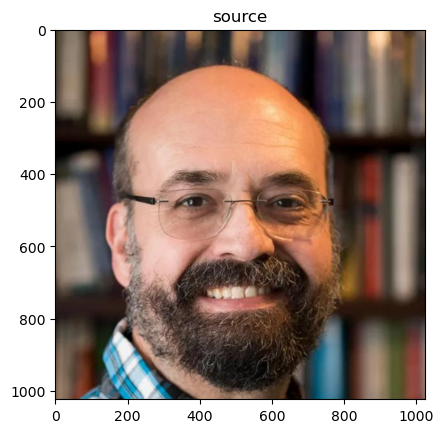

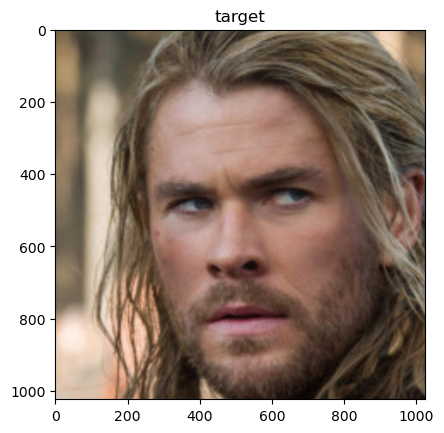

True

In [22]:
image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Target image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))